### Keras NN model

In [23]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

In [19]:
def resnet_layer(inputs,
                num_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                batch_normalization=True,
                conv_first=True):
    conv = Conv2D(num_filters,
                 kernel_size=strides,
                 padding='same',
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [20]:
def resnet_v2(input_shape, depth, num_classes=7):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
    input_shape (tensor): shape of input image tensor
    depth (int): number of core convolutional layers
    num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
    model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
        
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                    num_filters=num_filters_in,
                    conv_first=True)
    
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            # num of param setting 
            if stage == 0: # first stage
                num_filters_out = num_filters_in * 4
                if res_block == 0: # first layer & first stage
                    activation = None
                    batch_normalization = False
            else: # second, third stage
                num_filters_out = num_filters_in * 2
                if res_block == 0: # first layer but no first stage
                    strides = 2 # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters_in,
                            kernel_size=1,
                            strides=strides,
                            activation=activation,
                            batch_normalization=batch_normalization,
                            conv_first=False)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters_in,
                            conv_first=False)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters_out,
                            kernel_size=1,
                            conv_first=False)
            if res_block == 0:
                # Linear projection residual shortcut connection to match
                # changed dims
                # at the first time, make a shortcut origin
                x = resnet_layer(inputs=x,
                                num_filters=num_filters_out,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            # and add every reputation
            x = keras.layers.add([x, y])
        
        num_filters_in = num_filters_out
    
    # Add classifier on top
    # v2 has BN_ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                   activation='softmax',
                   kernel_initializer='he_normal')(y)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [31]:
def load_model(weight_path='../emotion_detector_models/model_resnet_best.hdf5'):
    # Create the model
    n = 6
    version = 2
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    input_shape = [48,48,1]

    model = resnet_v2(input_shape=input_shape, depth=depth)
    
    model.load_weights(weight_path)
    
    return model

### Prorotype Model

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# import dlib

In [5]:
frame = cv2.imread('../Sample_Pic_OD/HJ.jpg')
protoFile = "../caffemodels/pose_deploy_linevec.prototxt"
weightFile = "../caffemodels/pose_iter_440000.caffemodel"
faceHarr = cv2.CascadeClassifier('../harrs/haarcascade_frontalface_default.xml')
network = cv2.dnn.readNetFromCaffe(protoFile, weightFile)

def getSkeleton(frame, network, face_cascade, isHarr=True):
    ### Inferencing Pose ###
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],\
                  [6,7],[1,8],[8,9],[9,10], [14,11], [11,12], [12,13] ]
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
            "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
            "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
            "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    idx_2_BODY_PARTS = {int(num):part for part, num in BODY_PARTS.items()}
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    
    # inHeight / inWidth
    inWidth = 368
    inHeight = 368
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0/255, (inWidth, inHeight),\
                                   (0,0,0), swapRB=False, crop=False)
    
    dotsize = int((frameWidth + frameHeight) / (inWidth))
    textsize = int((frameWidth + frameHeight) / (inWidth * 4))
    linesize = dotsize // 2
    
    network.setInput(inpBlob)
    
    output = network.forward()
    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    points_with_num = []
    facelist = []
    
    ### Inferencing face & emotion ###
    if isHarr:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        facelist = face_cascade.detectMultiScale(gray, 1.3, 5)
        facelist = list(np.array(facelist).flatten())[:4]
    else:
        import dlib
        hogFaceDetector = dlib.get_frontal_face_detector()
        faceRects = hogFaceDetector(frame, 0)
        facelist = [faceRects[0].left(),faceRects[0].top(),\
                                              faceRects[0].right()-faceRects[0].left(), faceRects[0].bottom()-faceRects[0].top()]
    
    emotion = None
    print(facelist)
    if len(facelist)!=0:
        (fx,fy,fw,fh) = list(map(int,facelist))
        print(type(fx),type(fy),type(fw),type(fh))
        face = cv2.cvtColor(frame[fy:fy+fh, fx:fx+fw], cv2.COLOR_BGR2GRAY)
        plt.imshow(face, cmap='gray')
        face = cv2.resize(face, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
        input_face= face.reshape(-1,48,48,1)
        model = load_model()
        label_dict = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
        label_dict = {num:emotion for emotion, num in label_dict.items()}
        emotion = label_dict[np.argmax(model.predict(input_face))]
    
    ### Draw points, lines, rectangle ###
    ### Pose estimation ###
    for i in range(nPoints):
        # confidence map of corresponding body's part
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold:
            cv2.circle(frameCopy, (int(x), int(y)), dotsize, (0,255,255),\
                      thickness=dotsize, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)),\
                       cv2.FONT_HERSHEY_SIMPLEX, textsize, (0,0,255), textsize, \
                       lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), dotsize, (0, 0, 255),\
                       thickness=dotsize, lineType=cv2.FILLED)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
            points_with_num.append((int(x), int(y), int(i), idx_2_BODY_PARTS[int(i)]))
        else:
            points.append(None)
    
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0,255,255), linesize)
    
    ### Draw Face box and emotion ###
    if len(facelist)!=0:
        cv2.rectangle(frame, (int(fx),int(fy)),(int(fx+fw),int(fy+fh)),(0,255,0), linesize)
        cv2.rectangle(frameCopy, (int(fx),int(fy)),(int(fx+fw),int(fy+fh)),(0,255,0), linesize)
    
    img_skeleton = frame
    img_with_dot = frameCopy
    return img_skeleton, img_with_dot, points_with_num, emotion

### Test

[1065, 1033, 227, 227]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>


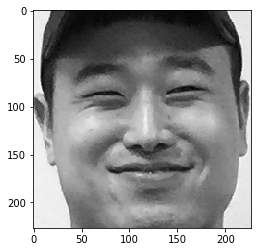

In [32]:
# import tensorflow as tf

# config = tf.ConfigProto()

# config.gpu_options.allow_growth = True

# sess = tf.Session(config=config)
frame = cv2.imread('../Sample_Pic_OD/HJ.jpg')
emotion_list = []
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
emotion_list.append(emotion)

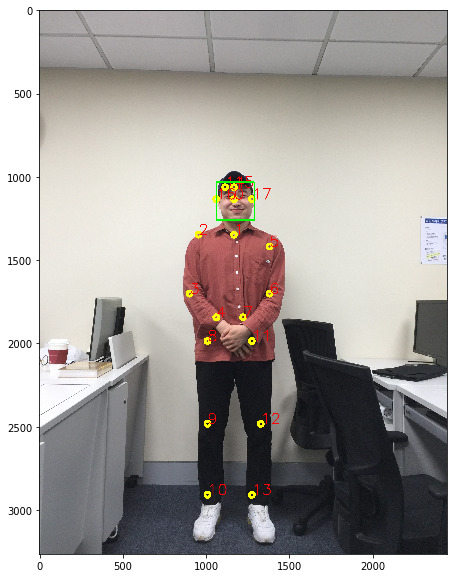

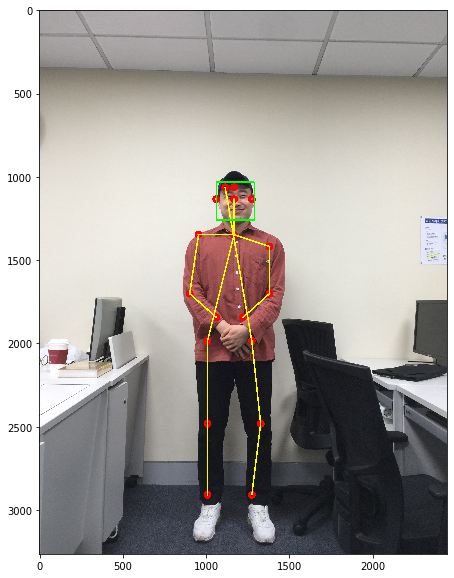

In [33]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))

In [34]:
emotion

'Surprise'

[1109, 575, 285, 285]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>
Surprise


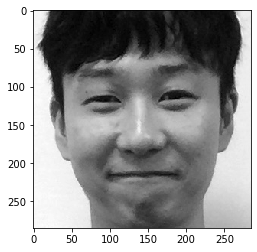

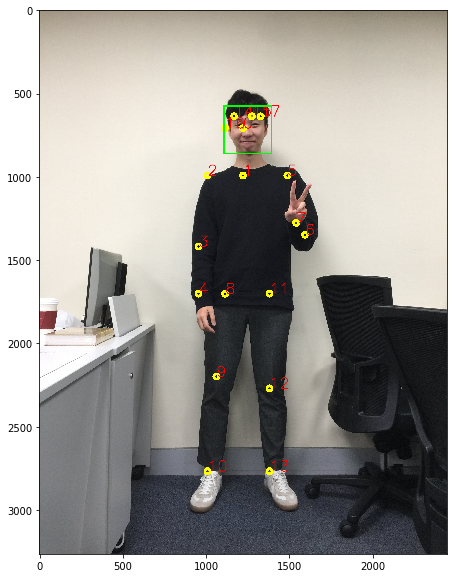

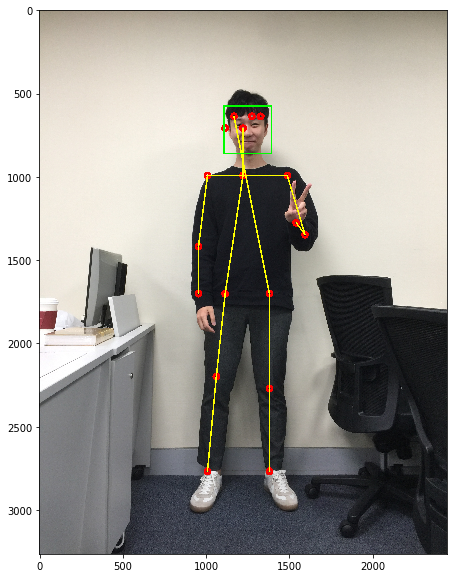

In [35]:
frame = cv2.imread('../Sample_Pic_OD/YK.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network,faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)
emotion_list.append(emotion)

[1189, 1066, 206, 206]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>
Surprise


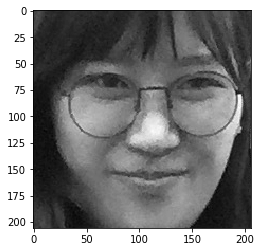

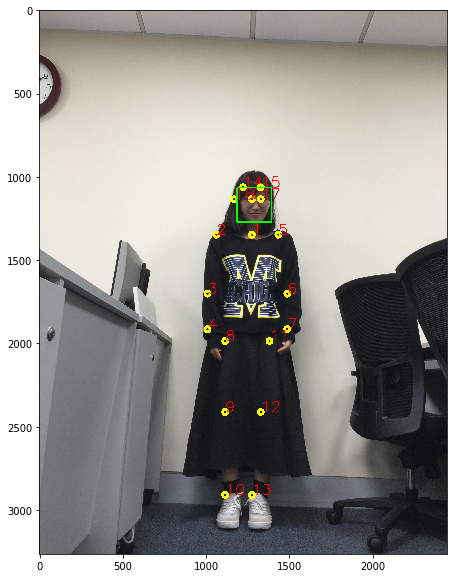

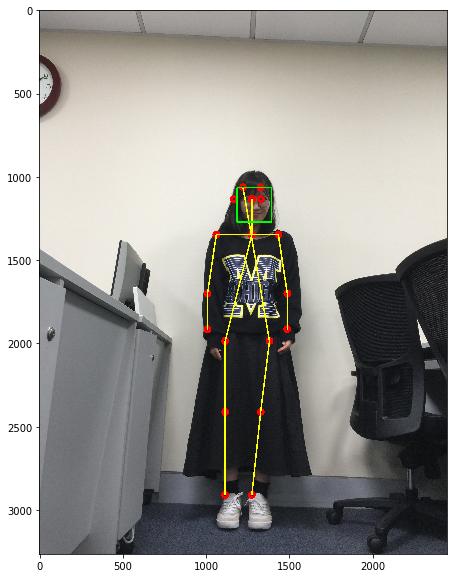

In [36]:
frame = cv2.imread('../Sample_Pic_OD/YJ.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)
emotion_list.append(emotion)

[1154, 542, 238, 238]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>
Surprise


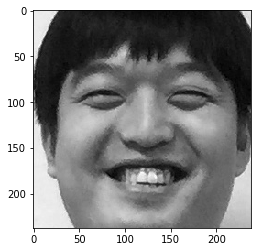

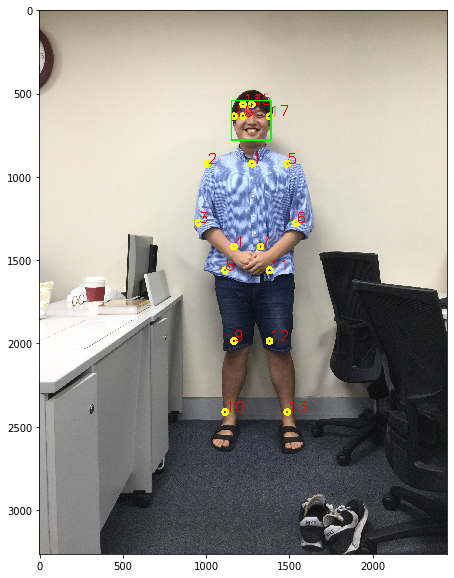

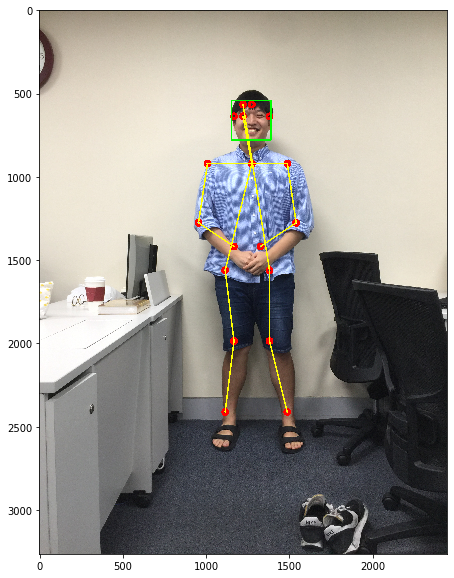

In [37]:
frame = cv2.imread('../Sample_Pic_OD/TH.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)
emotion_list.append(emotion)

[93, 12, 56, 56]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>
Angry


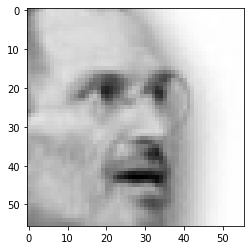

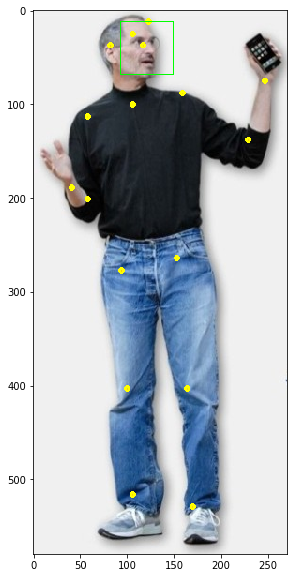

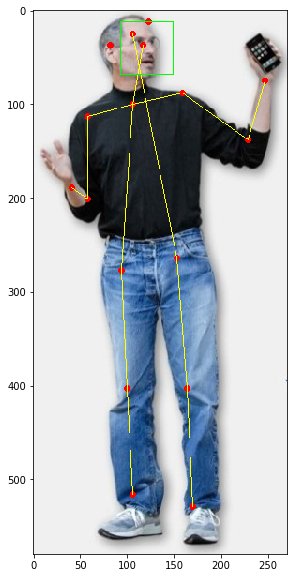

In [38]:
frame = cv2.imread('../Sample_Pic_OD/SJ.PNG')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)
emotion_list.append(emotion)

[256, 29, 209, 209]
<class 'int'> <class 'int'> <class 'int'> <class 'int'>
Surprise


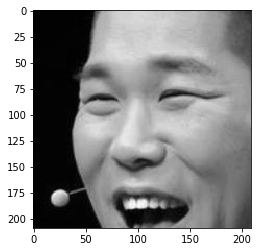

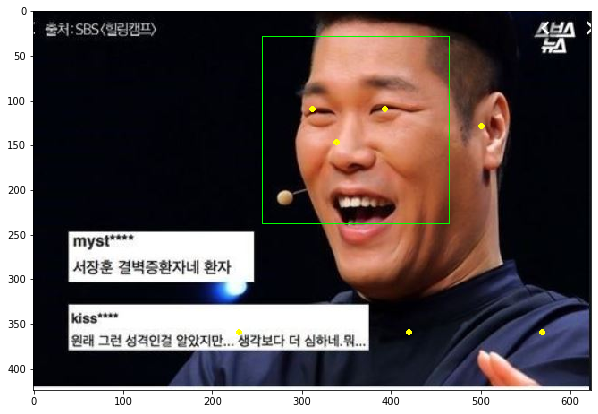

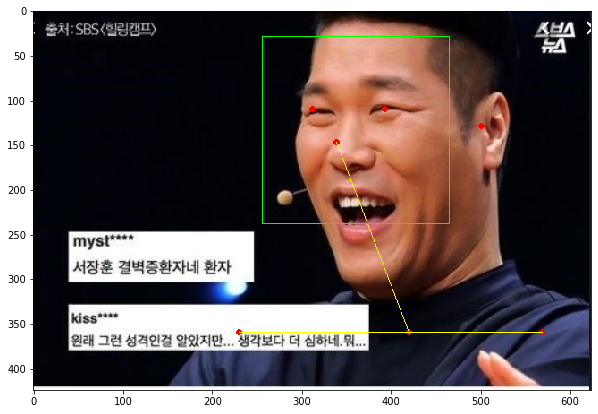

In [40]:
frame = cv2.imread('../Sample_Pic_OD/SJH.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)
emotion_list.append(emotion)

### Functions for visualization

In [39]:
import os

def emotion_hist(emo_list, savedir, savename):
    df = pd.DataFrame(emo_list, columns=['emotion'])
    ax = sns.countplot(x='emotion', data=df)
    plt.title('count of each sentiment')
    plt.show()
    fig = ax.get_figure()
    fig.savefig(os.path.join(savedir, savename))

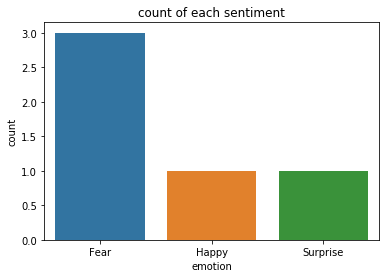

In [14]:
sv_dir = '../Sample_Pic_OD'
sv_name = 'sentiments.jpg'
emotion_hist(emotion_list, sv_dir, sv_name)

Text(0.5, 1.0, 'count of each sentiment')

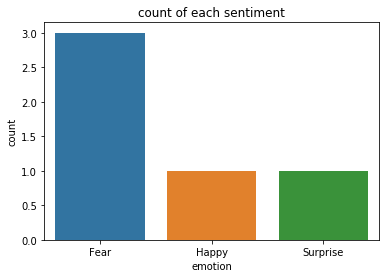

In [15]:
df = pd.DataFrame(emotion_list, columns=['emotion'])
sns.countplot(x='emotion', data=df)
plt.title('count of each sentiment')

In [16]:
points

[(117, 37, 0, 'Nose'),
 (106, 100, 1, 'Neck'),
 (58, 113, 2, 'RShoulder'),
 (58, 201, 3, 'RElbow'),
 (41, 189, 4, 'RWrist'),
 (159, 88, 5, 'LShoulder'),
 (229, 138, 6, 'LElbow'),
 (247, 75, 7, 'LWrist'),
 (94, 277, 8, 'RHip'),
 (100, 403, 9, 'RKnee'),
 (106, 516, 10, 'RAnkle'),
 (153, 264, 11, 'LHip'),
 (164, 403, 12, 'LKnee'),
 (170, 529, 13, 'LAnkle'),
 (106, 25, 14, 'REye'),
 (123, 12, 15, 'LEye'),
 (82, 37, 16, 'REar')]

In [141]:
points_list = [[(222, 86, 0, 'Nose'), (222, 195, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (97, 344, 3, 'RElbow'), (194, 352, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (320, 273, 6, 'LElbow'), (333, 328, 7, 'LWrist'), (180, 352, 8, 'RHip'), (306, 336, 11, 'LHip'), (194, 78, 14, 'REye'), (236, 78, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 93, 17, 'LEar')], [(236, 101, 0, 'Nose'), (222, 195, 1, 'Neck'), (153, 195, 2, 'RShoulder'), (125, 289, 3, 'RElbow'), (180, 344, 4, 'RWrist'), (306, 195, 5, 'LShoulder'), (320, 273, 6, 'LElbow'), (292, 344, 7, 'LWrist'), (166, 352, 8, 'RHip'), (278, 352, 11, 'LHip'), (208, 93, 14, 'REye'), (250, 93, 15, 'LEye'), (180, 101, 16, 'REar'), (264, 101, 17, 'LEar')], [(222, 86, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (111, 273, 3, 'RElbow'), (111, 313, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (333, 273, 6, 'LElbow'), (333, 313, 7, 'LWrist'), (194, 78, 14, 'REye'), (236, 78, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 93, 17, 'LEar')], [(236, 86, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 187, 2, 'RShoulder'), (111, 344, 3, 'RElbow'), (166, 305, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (347, 328, 6, 'LElbow'), (278, 313, 7, 'LWrist'), (208, 78, 14, 'REye'), (250, 78, 15, 'LEye'), (180, 93, 16, 'REar')], [(222, 93, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (111, 281, 3, 'RElbow'), (111, 344, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (320, 266, 6, 'LElbow'), (320, 336, 7, 'LWrist'), (292, 352, 11, 'LHip'), (208, 86, 14, 'REye'), (250, 86, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')], [(236, 93, 0, 'Nose'), (222, 195, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (125, 289, 3, 'RElbow'), (180, 352, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (347, 320, 6, 'LElbow'), (278, 344, 7, 'LWrist'), (180, 352, 8, 'RHip'), (292, 352, 11, 'LHip'), (208, 78, 14, 'REye'), (250, 78, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')], [(222, 101, 0, 'Nose'), (236, 187, 1, 'Neck'), (153, 187, 2, 'RShoulder'), (125, 281, 3, 'RElbow'), (111, 336, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (333, 273, 6, 'LElbow'), (320, 328, 7, 'LWrist'), (194, 93, 14, 'REye'), (236, 86, 15, 'LEye'), (180, 101, 16, 'REar'), (264, 101, 17, 'LEar')], [(208, 101, 0, 'Nose'), (236, 195, 1, 'Neck'), (153, 195, 2, 'RShoulder'), (125, 289, 3, 'RElbow'), (153, 328, 4, 'RWrist'), (306, 195, 5, 'LShoulder'), (333, 281, 6, 'LElbow'), (320, 328, 7, 'LWrist'), (194, 86, 14, 'REye'), (222, 86, 15, 'LEye'), (180, 101, 16, 'REar'), (264, 93, 17, 'LEar')], [(222, 93, 0, 'Nose'), (222, 187, 1, 'Neck'), (153, 187, 2, 'RShoulder'), (97, 328, 3, 'RElbow'), (41, 320, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (333, 273, 6, 'LElbow'), (389, 297, 7, 'LWrist'), (208, 86, 14, 'REye'), (250, 86, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')], [(222, 93, 0, 'Nose'), (222, 195, 1, 'Neck'), (153, 195, 2, 'RShoulder'), (97, 281, 3, 'RElbow'), (97, 328, 4, 'RWrist'), (306, 195, 5, 'LShoulder'), (333, 273, 6, 'LElbow'), (320, 344, 7, 'LWrist'), (292, 352, 11, 'LHip'), (208, 78, 14, 'REye'), (236, 78, 15, 'LEye'), (180, 101, 16, 'REar'), (264, 101, 17, 'LEar')], [(222, 93, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (55, 336, 3, 'RElbow'), (41, 258, 4, 'RWrist'), (306, 187, 5, 'LShoulder'), (333, 266, 6, 'LElbow'), (333, 328, 7, 'LWrist'), (292, 352, 11, 'LHip'), (208, 78, 14, 'REye'), (250, 78, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')], [(236, 101, 0, 'Nose'), (222, 195, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (125, 289, 3, 'RElbow'), (194, 352, 4, 'RWrist'), (306, 195, 5, 'LShoulder'), (320, 273, 6, 'LElbow'), (278, 344, 7, 'LWrist'), (292, 352, 11, 'LHip'), (208, 86, 14, 'REye'), (250, 93, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')], [(236, 101, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 187, 2, 'RShoulder'), (97, 289, 3, 'RElbow'), (306, 187, 5, 'LShoulder'), (333, 336, 6, 'LElbow'), (278, 305, 7, 'LWrist'), (222, 86, 14, 'REye'), (250, 93, 15, 'LEye'), (180, 93, 16, 'REar')], [(222, 93, 0, 'Nose'), (222, 195, 1, 'Neck'), (139, 195, 2, 'RShoulder'), (97, 336, 3, 'RElbow'), (194, 352, 4, 'RWrist'), (306, 195, 5, 'LShoulder'), (333, 328, 6, 'LElbow'), (264, 344, 7, 'LWrist'), (180, 352, 8, 'RHip'), (292, 352, 11, 'LHip'), (208, 78, 14, 'REye'), (236, 78, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 93, 17, 'LEar')], [(236, 101, 0, 'Nose'), (222, 187, 1, 'Neck'), (139, 187, 2, 'RShoulder'), (111, 281, 3, 'RElbow'), (306, 195, 5, 'LShoulder'), (320, 266, 6, 'LElbow'), (333, 328, 7, 'LWrist'), (166, 352, 8, 'RHip'), (278, 352, 11, 'LHip'), (222, 86, 14, 'REye'), (250, 86, 15, 'LEye'), (180, 93, 16, 'REar'), (264, 101, 17, 'LEar')]]
emotions = ['None', 'Fear', 'Fear', 'Happy', 'Fear', 'Fear', 'Happy', 'Fear', 'Fear', 'Happy', 'Happy', 'Fear', 'Angry', 'Happy', 'Surprise']

## Emotions : emotion들이 기록된 list

In [142]:
# 각 emotion의 등장 횟수 및 pos / neg의 percent 제공
def countEmotions(emotions):
    label_dict = {'Angry':'negative', 'Disgust':'negative', 'Fear':'negative', 'Happy':'positive', \
                  'Neutral':'neutral', 'Sad':'negative', 'Surprise':'positive', 'None':'neutral'}
    emotion_counts = {'positive' : 0, 'negative' : 0, 'neutral' : 0}
    for emotion in emotions:
        emotion_counts[label_dict[emotion]] += 1
        
    sum_emo_cnt = emotion_counts['positive'] + emotion_counts['negative'] + \
                    emotion_counts['neutral']
    
    per_pos = emotion_counts['positive'] / sum_emo_cnt
    per_neg = emotion_counts['negative'] / sum_emo_cnt
    per_neut = emotion_counts['neutral'] /sum_emo_cnt
    
    return emotion_counts, (per_pos, per_neg, per_neut)

In [143]:
countEmotions(emotions)

({'positive': 6, 'negative': 8, 'neutral': 1},
 (0.4, 0.5333333333333333, 0.06666666666666667))

## frame을 전부 거친 후에, 각 frame의 point들이 저장된 points_list라는 list를 받아 수행하도록 설계

### function for converting from list to dict

In [144]:
def li2dict(points_list):
    tmp_li = []
    for k in range(len(points_list)):
        t = {points_list[k][i][2]: (points_list[k][i][0],points_list[k][i][1],points_list[k][i][3]) for i in range(len(points_list[k]))}
        tmp_li.append(t)
    return tmp_li

In [145]:
points_list = li2dict(points_list)

In [146]:
points_list

[{0: (222, 86, 'Nose'),
  1: (222, 195, 'Neck'),
  2: (139, 195, 'RShoulder'),
  3: (97, 344, 'RElbow'),
  4: (194, 352, 'RWrist'),
  5: (306, 187, 'LShoulder'),
  6: (320, 273, 'LElbow'),
  7: (333, 328, 'LWrist'),
  8: (180, 352, 'RHip'),
  11: (306, 336, 'LHip'),
  14: (194, 78, 'REye'),
  15: (236, 78, 'LEye'),
  16: (180, 93, 'REar'),
  17: (264, 93, 'LEar')},
 {0: (236, 101, 'Nose'),
  1: (222, 195, 'Neck'),
  2: (153, 195, 'RShoulder'),
  3: (125, 289, 'RElbow'),
  4: (180, 344, 'RWrist'),
  5: (306, 195, 'LShoulder'),
  6: (320, 273, 'LElbow'),
  7: (292, 344, 'LWrist'),
  8: (166, 352, 'RHip'),
  11: (278, 352, 'LHip'),
  14: (208, 93, 'REye'),
  15: (250, 93, 'LEye'),
  16: (180, 101, 'REar'),
  17: (264, 101, 'LEar')},
 {0: (222, 86, 'Nose'),
  1: (222, 187, 'Neck'),
  2: (139, 195, 'RShoulder'),
  3: (111, 273, 'RElbow'),
  4: (111, 313, 'RWrist'),
  5: (306, 187, 'LShoulder'),
  6: (333, 273, 'LElbow'),
  7: (333, 313, 'LWrist'),
  14: (194, 78, 'REye'),
  15: (236, 78, 'L

In [147]:
1 in points_list[0].keys()

True

### count number or eyes

### 각 화면에서 눈의 갯수

In [148]:
def countEyes(points):
    eyecount = 0
    if 14 in points.keys() :
        eyecount += 1
    if 15 in points.keys() :
        eyecount += 1
    return eyecount

In [149]:
points = points_list[0]
countEyes(points)
# by this func, we can make easy scoring : summension or average

2

In [150]:
len(points_list)

15

In [151]:
def countTotalEyes(points_list):
    total_eye_cnt = 0
    see_front_cnt = 0
    len_snapshot = len(points_list)
    for points in points_list:
        pt = countEyes(points)
        total_eye_cnt += pt
        if pt:
            see_front_cnt += 1
    per_see_front = total_eye_cnt / (len_snapshot*2)
    return total_eye_cnt, see_front_cnt, per_see_front

In [152]:
countTotalEyes(points_list)

(30, 15, 1.0)

### hand moving

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time

def checkHandMoving(points_list, save_path='./'):
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
        "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
        "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
        "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    li = []
     # right shoulder, right elbow, rirhg wrist / left s, left e, left w
    for i in range(6):
        li.append([])
    for points in points_list:
        if 2 in points.keys():
            li[0].append(points[2][0:2])
        if 3 in points.keys():
            li[1].append(points[3][0:2])
        if 4 in points.keys():
            li[2].append(points[4][0:2])
        if 5 in points.keys():
            li[3].append(points[5][0:2])
        if 6 in points.keys():
            li[4].append(points[6][0:2])
        if 7 in points.keys():
            li[5].append(points[7][0:2])
    
#     print(li)
    
    mean_std_list = [] # order is same
    for i in range(6):
        p_list = np.array(li[i])
        p_std = p_list.std(axis=0).sum()
        p_mean = p_list.mean(axis=0).sum()
        mean_std_list.append([p_mean, p_std])
#         print(p_list)
#         print(p_std)
#         print(p_mean)
        
    df = pd.DataFrame(mean_std_list, columns=['p_mean','p_std'])
#     print(df)
        
    # matplotlib => savefig로 보여주는 것이 좋겠다
    # var, difference의 변화과정 보여주기
    
    f, ax = plt.subplots(1,1,figsize=(10,8))
#     f.set_title('Mean & Variance of arms move')
    df['p_std'].plot(kind='bar', ax=ax)
    filename = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
    filename = filename + "_mean_std_plot"
    plt.savefig(os.path.join(save_path,filename))
    
    return mean_std_list

[[336.0, 10.370899457402697],
 [409.26666666666665, 43.82576542225067],
 [465.9230769230769, 78.72942020551578],
 [496.2, 3.919183588453085],
 [617.3333333333334, 34.01471294804575],
 [639.5333333333333, 46.69899064177817]]

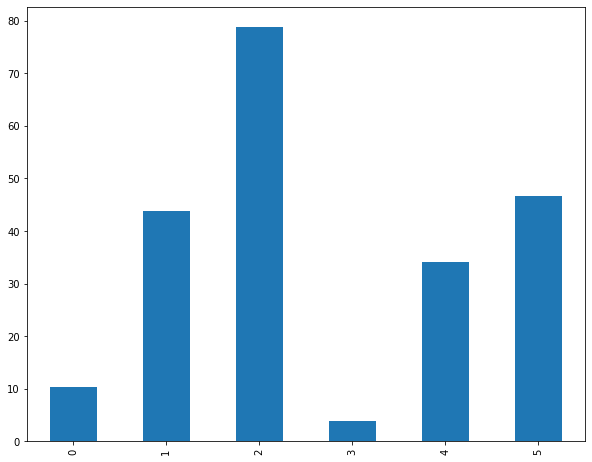

In [156]:
checkHandMoving(points_list) # 각 부위의 분산 : 각 부위가 얼마나 움직였는지 분석 : mean / std

### standing straightly

In [184]:
# 화면 1개의 점수
import math
import numpy as np

def checkStandingStraight(points):
    # check starightness between the middle point of LHip, RHip and Neck
    is_straight = False
    if 1 in points.keys() and 8 in points.keys() and 11 in points.keys():
        neck = np.array(points[1][0:2])
        rhip = np.array(points[8][0:2])
        lhip = np.array(points[11][0:2])
        mp = (rhip + lhip) / 2
#         ap = np.array([mp[0],neck[1]])
        val = math.sqrt(math.pow(mp[0]-neck[0],2) + math.pow(mp[1]-neck[1],2))
        cos = abs(mp[1]-neck[1]) / val
        rad = math.acos(cos)
        if rad * 57.296 < 15:
            is_straight = True
        return (True, rad * 57.296, is_straight) # exist, degree, straight or not
    else:
        return (False, 0, is_straight)

In [185]:
checkStandingStraight(points)

(True, 8.02243451932309, True)

In [230]:
import numpy as np
def checkStandingStraight_group(points_list):
    # check starightness between the middle point of LHip, RHip and Neck
    res_list = np.zeros(3) # cnt_ok, avg_degree, straight_percent
    for points in points_list:
        is_ok, degree, is_st = checkStandingStraight(points)
        if is_ok:
            res_list[0] += 1
            res_list[1] += degree
            if is_st:
                res_list[2] += is_st
    
    return res_list / res_list[0]

In [231]:
# 이런식으로 잘 서있다! 라고 알려줌

In [232]:
checkStandingStraight_group(points_list)

array([1.        , 3.64277472, 1.        ])

### left_right balance : shoulder + hip

In [197]:
def checkLeftRightBalance(points):
    is_balanced = False
    if 2 in points.keys() and 5 in points.keys() and 8 in points.keys() and 11 in points.keys():
        rsh = np.array(points[2][0:2])
        lsh = np.array(points[5][0:2])
        val = math.sqrt(math.pow(rsh[0]-lsh[0],2) + math.pow(rsh[1]-lsh[1],2))
        cos = abs(rsh[1]-lsh[1]) / val
        s_rad = math.acos(cos)
        
        rhip = np.array(points[8][0:2])
        lhip = np.array(points[11][0:2])
        val = math.sqrt(math.pow(rhip[0]-lhip[0],2) + math.pow(rhip[1]-lhip[1],2))
        cos = abs(rhip[1]-lhip[1]) / val
        h_rad = math.acos(cos)
        
        if 90 - ((s_rad + h_rad) * 57.296) / 2 < 15:
            is_balanced = True
        return (True, 90 - s_rad * 57.296, 90 - h_rad * 57.296, is_balanced) # exist, s_degree, h_degree, straight or not
    else:
        return (False, 0, 0, is_balanced)

In [198]:
checkLeftRightBalance(points)

(True, 2.742275571620411, 7.236603535215025, True)

In [228]:
# group
import numpy as np
def checkLeftRightBalance_group(points_list):
    # check starightness between the middle point of LHip, RHip and Neck
    res_list = np.zeros(4) # cnt_ok, avg_degree_s, avg_degree_h, balanced_percent
    for points in points_list:
        is_ok, degree_s, degree_h, is_bal = checkLeftRightBalance(points)
#         print(checkLeftRightBalance(points))
        if is_ok:
            res_list[0] += 1
            res_list[1] += degree_s
            res_list[2] += degree_h
            if is_bal:
                res_list[3] += is_bal
#         print(res_list)
    return res_list / res_list[0]    

In [229]:
checkLeftRightBalance_group(points_list)

array([1.        , 1.64522681, 1.44704364, 1.        ])

### screened by face : 아마 얼굴을 screen으로 가리면 너무 빛날 것이다 : 명도를 이용해서 해야 할 듯...?

In [215]:
def checkScreenedByFace(points):
    pass

### too much moving : 바들바들 떨고있는지? : 이건 좀 어렵나

### talk to the ground

### (hands in the pocket) => Don't Hide your hands : 자신감 있는 발표를 위해 손을 숨기지 마세요!
### 근데 솔직히 좀 이건 너무 비약 => new 모델 필요! : hand detection!

In [216]:
def checkHideHands(points):
    is_Hide_Hands = False
    if 8 in points.keys() and 9 in points.keys() and 10 in points.keys() and 11 in points.keys() \
        and 12 in points.keys() and 13 in points.keys():
        if 4 not in points.keys() or 7 not in points.keys():
            is_Hide_Hands = True
        return (True, is_Hide_Hands)
    else:
        return (False, is_Hide_Hands)

In [222]:
checkHideHands(points)

(False, False)

### crossed your arms : 팔짱을 낀 것은 아닌지

In [224]:
def checkCrossArms(points):
    is_crossed = False
    if 2 in points.keys() and 4 in points.keys() and 5 in points.keys() and 7 in points.keys():
        if (points[2][0] - points[5][0]) * (points[4][0] - points[7][0]) < 0:
            is_crossed = True
        return (True, is_crossed) # is_ok, is_crossed
    else:
        return (False, is_crossed)

In [227]:
checkCrossArms(points_list[3])

(True, False)

In [233]:
def checkCrossArms_group(points_list):
    res_list = np.zeros(2)
    for points in points_list:
        is_ok, is_crossed = checkCrossArms(points)
        if is_ok:
            res_list[0] += 1
            if is_crossed:
                res_list[1] += 1
    
    return res_list / res_list[0]            

In [234]:
checkCrossArms_group(points_list)

array([1., 0.])

### putting hands on the head : 머리 위에 손을 얹은건 아닌지

In [238]:
def checkPutHandsOnHead(points):
    is_put = False
    if 4 in points.keys() and 1 in points.keys() and 7 in points.keys():
        if points[1][1] > points[4][1] and points[1][1] > points[7][1]:
            is_put = True
        return (True, is_put)
    else:
        return (False, is_put)    

In [239]:
checkPutHandsOnHead(points_list[3])

(True, False)

In [242]:
def checkPutHandsOnHead_group(points_list):
    res_list = np.zeros(2)
    for points in points_list:
        is_ok, is_put = checkPutHandsOnHead(points)
        if is_ok:
            res_list[0] += 1
            if is_put:
                res_list[1] += 1
    
    return res_list / res_list[0]  

In [243]:
checkPutHandsOnHead_group(points_list)

array([1., 0.])